In [35]:
import polars as pl 
import polars.selectors as cs 
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from yahoo_fin.stock_info import get_data
import phoenix as px 
import umap

c:\Users\faune\miniconda3\envs\thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
sentences = pl.read_parquet(r"C:\Users\faune\Desktop\thesis\daily_headlines.parquet")

In [ ]:
msci_world = get_data(ticker="^990100-USD-STRD", start_date="2008-01-01", end_date="2016-01-01")

In [ ]:
msci_close = pl.DataFrame(msci_world[['close']].dropna().pct_change().reset_index())

In [ ]:
to_join = msci_close.drop_nulls().with_columns(pl.col('index').cast(pl.Date)).rename({'index': 'date'})

In [39]:
sentences = sentences.with_columns(pl.col('date').cast(pl.Date))

In [ ]:
sentences

In [40]:
frame = sentences.join(to_join, on='date').with_columns(pl.col('date').dt.year().alias('year'))

In [41]:
reducer = umap.UMAP()

In [42]:
reduced = reducer.fit_transform(frame.select('embeddings').to_series().to_list())

In [43]:
frame = frame.with_columns(pl.Series(name = 'reduced', values = reduced))

<Axes: xlabel='x', ylabel='y'>

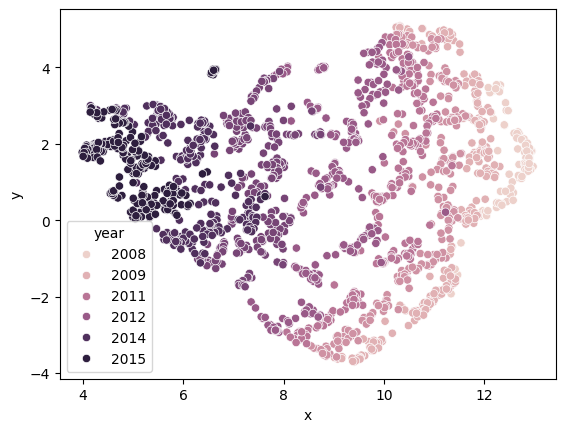

In [49]:
sns.scatterplot(data = frame.with_columns(pl.col('reduced').list.to_struct()).unnest('reduced').rename({'field_0':'x', 'field_1':'y'}).select('x','y', 'year').to_pandas(), x= 'x', y = 'y', hue='year')